Чтобы подключиться к локальной сети, ввести
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com'

#Подготовка датасета

Датасет https://www.kaggle.com/datasets/rahulsah06/gooogle-stock-price

In [ ]:
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.utils.data as data
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print("used:", device, "-", torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'cpu')

used: cpu - cpu


In [ ]:
test_data_dir = "D:\\stasya\\univer\\NN\\2\\Google_Stock_Price_Test.csv"
data_dir = "D:\\stasya\\univer\\NN\\2\\Google_Stock_Price_Train.csv"
df = pd.read_csv(data_dir)
df

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [ ]:
# Убираем все лишнее
df = df.loc[:, ["High"]]
df.shape

(1258, 1)

Сгенерируем наблюдения с временной задержкой. Это те же значения, но с задержкой

In [ ]:
n_shift = 100 #насколько задерживаются данные 
df["High2"] = df["High"].shift(n_shift)
df = df.dropna()
df

,High,High2
100,299.74,332.83
101,298.45,333.87
102,294.84,330.75
103,293.90,328.77
104,285.26,322.29
...,...,...
1253,792.74,773.21
1254,797.86,774.07
1255,794.23,783.04
1256,785.93,782.63


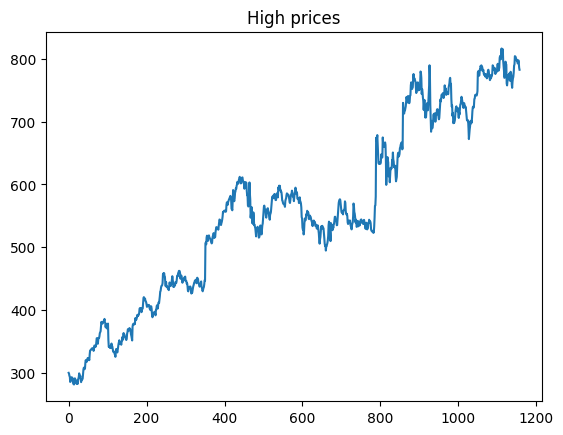

In [ ]:
plt.plot(df[["High"]].values)
plt.title("High prices")
plt.show()

Делим данные

In [ ]:
from sklearn.model_selection import train_test_split

def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df, target_col):
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, #доля данных для теста
                                                        shuffle=False) # не перетасовывать
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df, 'High')

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

In [ ]:
scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_test_arr = scaler.transform(X_test)
X_val_arr = scaler.transform(X_val)

y_train_arr = scaler.fit_transform(y_train)
y_test_arr = scaler.transform(y_test)
y_val_arr = scaler.transform(y_val)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, 
                          drop_last=True) # отбрасывать последний неполный пакет
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(TensorDataset(test_features, test_targets), batch_size=1, shuffle=False, drop_last=True)

#Архитектура

## RNN

In [ ]:
from torch import nn

class Net1(nn.Module):
    def __init__(self, 
                 input_size, # размер входных данных (в нашем случае к-во строк)
                 out_size, # Количество узлов в выходном слое
                 hidden_size, # количество узлов в скрытых слоях
                 num_layers): # Количество повторяющихся слоев. Например при =2, 2 RNN складываются
        super(self.__class__, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, 
            batch_first=True, # если True, то данные предоставляются как 1 упакованная последовательность
             nonlinearity ='relu') #Нелинейность в использовании
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        #сначала заполняем все 0
        h0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_().to(device)

       # Прямое распространение путем передачи входного и скрытого состояний в модель
        out, h0 = self.rnn(x, h0.detach())

        # Преобразуем в желаемую форму вывода
        out = self.fc(out)
        return out
    
net1 = Net1(input_size=len(X_train.columns), out_size=1, 
    hidden_size=32, num_layers=3)

Сделаем 1 слой вместо 3

In [ ]:
net2 = Net1(input_size=len(X_train.columns), out_size=1, 
    hidden_size=32, num_layers=1)

Увеличим количество узлов в скрытых слоях

In [ ]:
net3 = Net1(input_size=len(X_train.columns), out_size=1, 
    hidden_size=64, num_layers=3)

Изменим и то и то

In [ ]:
net4 = Net1(input_size=len(X_train.columns), out_size=1, 
    hidden_size=64, num_layers=1)

##LSTM

In [ ]:
models = list()

class NetLSTM(nn.Module):
    def __init__(self, input_size, out_size, hidden_size, num_layers):
        super(self.__class__, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_().to(device)

        # Прямое распространение путем передачи входного и скрытого состояний в модель
        out, h0 = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out)
        return out
    
netLSTM = NetLSTM(input_size=len(X_train.columns), out_size=1, 
    hidden_size=64, num_layers=1)

## GRU

In [ ]:
class NetGRU(nn.Module):
    def __init__(self, input_size, out_size, hidden_size, num_layers):
        super(self.__class__, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.gru = nn.GRU(
            input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_().to(device)
        
        out, h0 = self.gru(x, h0.detach())

        out = self.fc(out)
        return out
    
netGRU = NetGRU(input_size=len(X_train.columns), out_size=1, 
    hidden_size=64, num_layers=1)

#Тренировка и вывод

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime
import torch.optim as optim

class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model 
        self.loss_fn = loss_fn # Функция потерь для расчета потерь
        self.optimizer = optimizer # функция оптимизатора для оптимизации функции потерь
        self.train_losses = [] # Значения потерь при тренировке
        self.val_losses = [] # Значения потерь в результате проверки
        
    # шаг обучения   
    def train_step(self, x, # Тензор для обучения
                   y): # Тензор для расчета потерь
        # Переходим в режим обучения
        self.model.train()
        # Makes predictions
        yhat = self.model(x)
        # Computes loss
        loss = self.loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    # выполняет обучение модели
    def train(self, train_loader, # загрузчик данных, в котором хранятся обучающие данные
              val_loader, # Загрузчик данных, который хранит данные проверки
              batch_size=64, n_epochs=50):
        model_path = f'{self.model.__class__.__name__}'
        best_model_state = None
        best_loss = 9999999.0
        best_epoch = 0

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                # считаем ошибку
                batch_losses.append(loss)
            # среднее арифметическое всех ошибок
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    # считаем ошибку
                    val_loss = self.loss_fn(y_val, yhat).item()
                    # среднее арифметическое всех ошибок
                    batch_val_losses.append(val_loss)
                # среднее арифметическое значений элементов массива.
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
                
            if validation_loss < best_loss:
                best_loss = validation_loss
                best_epoch = epoch
                best_model_state = self.model.state_dict()

            if (epoch == 1) | (epoch % 50 == 0):
                print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}")
                
        self.best_epoch = epoch
        print(f"\tBest epoch: {best_epoch}")
        print(f"Best valid loss: {best_loss}")
        torch.save(best_model_state, model_path)

    def evaluate(self, 
                 test_loader, # Загрузчик данных, в котором хранятся тестовые данные
                 batch_size=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.cpu().detach().numpy())
                values.append(y_test.cpu().detach().numpy())

        return predictions, values

    #выводим ошибки
    def plot_losses(self):        
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

MSE = разница между предсказаниями вашей модели и основополагающей правдой, возводим ее в квадрат и усредняем ее по всему набору данных.


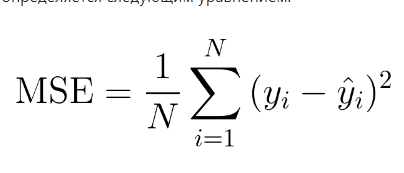

[1/100] Training loss: 0.1543	 Validation loss: 0.5822
[50/100] Training loss: 0.0107	 Validation loss: 0.1342
[100/100] Training loss: 0.0096	 Validation loss: 0.1319
	Best epoch: 20
Best valid loss: 0.11914714425802231


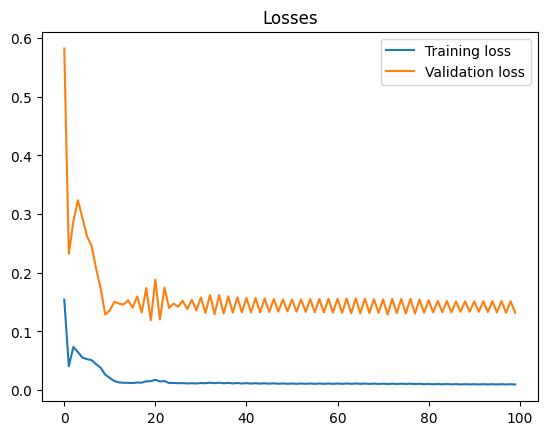

[1/100] Training loss: 0.1111	 Validation loss: 0.5766
[50/100] Training loss: 0.0125	 Validation loss: 0.1360
[100/100] Training loss: 0.0096	 Validation loss: 0.1269
	Best epoch: 8
Best valid loss: 0.09967232247193654


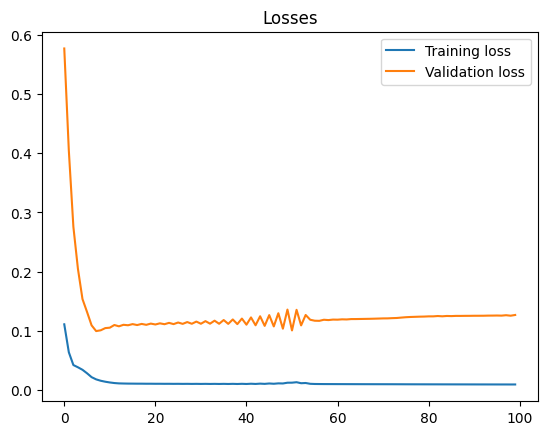

[1/100] Training loss: 0.2531	 Validation loss: 0.6134
[50/100] Training loss: 0.0163	 Validation loss: 0.1260
[100/100] Training loss: 0.0103	 Validation loss: 0.1316
	Best epoch: 18
Best valid loss: 0.07263488446672757


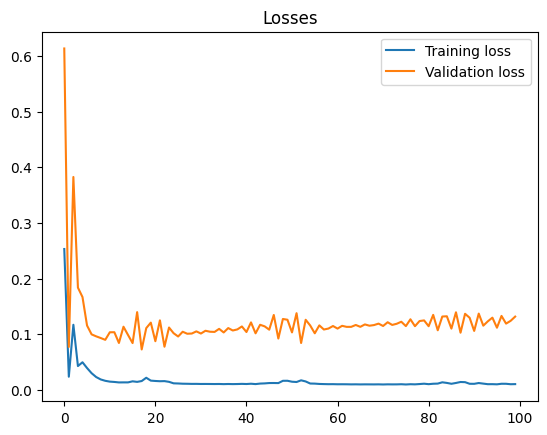

[1/100] Training loss: 0.2049	 Validation loss: 0.8134
[50/100] Training loss: 0.0110	 Validation loss: 0.0948
[100/100] Training loss: 0.0099	 Validation loss: 0.1051
	Best epoch: 20
Best valid loss: 0.08960584923624992


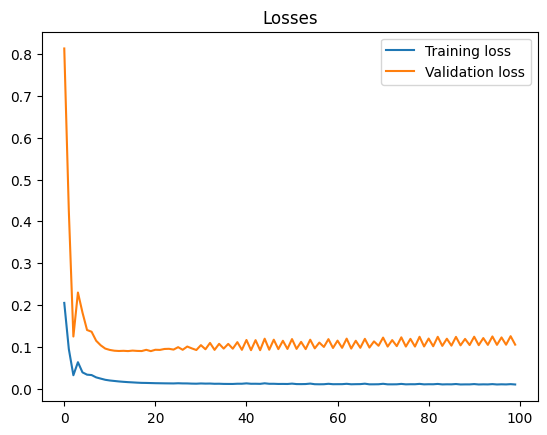

[1/100] Training loss: 0.1922	 Validation loss: 0.7078
[50/100] Training loss: 0.0141	 Validation loss: 0.1031
[100/100] Training loss: 0.0117	 Validation loss: 0.1218
	Best epoch: 2
Best valid loss: 0.09049784143765767


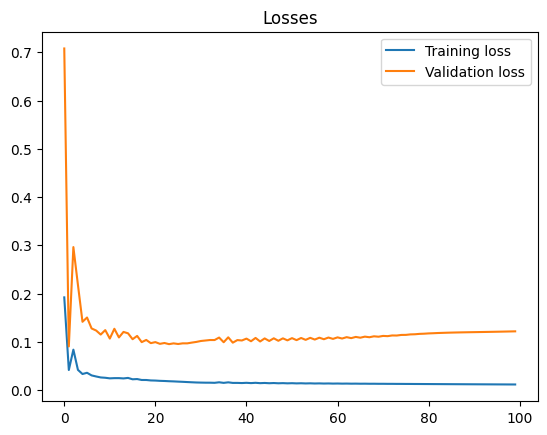

[1/100] Training loss: 0.2443	 Validation loss: 0.6231
[50/100] Training loss: 0.0158	 Validation loss: 0.0736
[100/100] Training loss: 0.0117	 Validation loss: 0.1014
	Best epoch: 53
Best valid loss: 0.07350704943140347


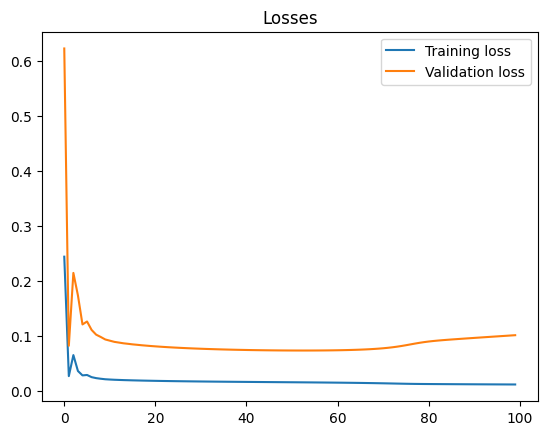

In [ ]:
import torch.optim as optim
models = [net1, net2, net3, net4, netLSTM, netGRU]
#models = [net1, net2, net3, net4]
num_epochs = 100
lr = 0.001 # скорость обучения, размер шага
weight_decay = 0.00001 # L2 регуляризация (штраф, уменьшение веса)

optimizers = list()
# средняя квадратичная функция потерь
loss_fn = nn.MSELoss()
# loss_fn = nn.L1Loss()

for model in models:
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
    optimizers.append(opt)

for opt in optimizers:
    opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=num_epochs)
    opt.plot_losses()

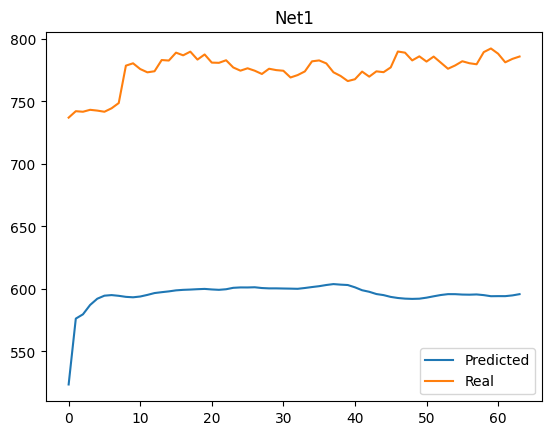

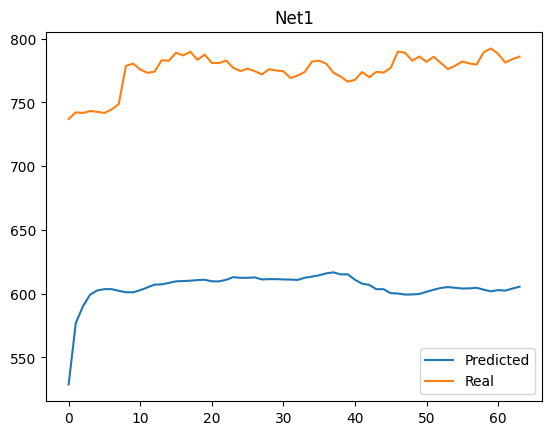

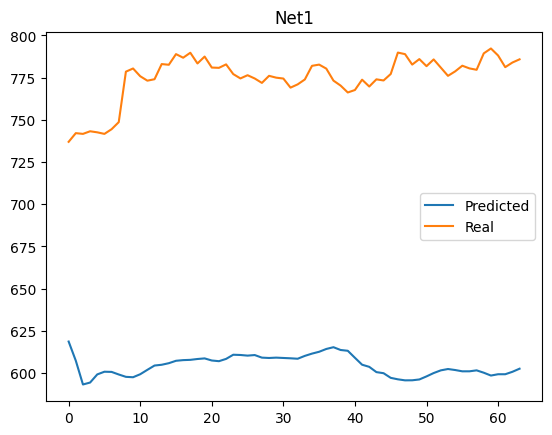

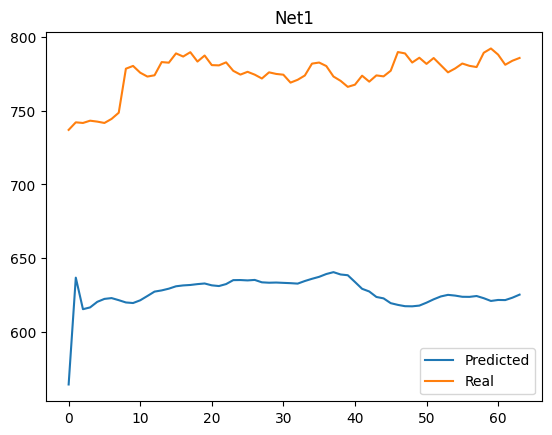

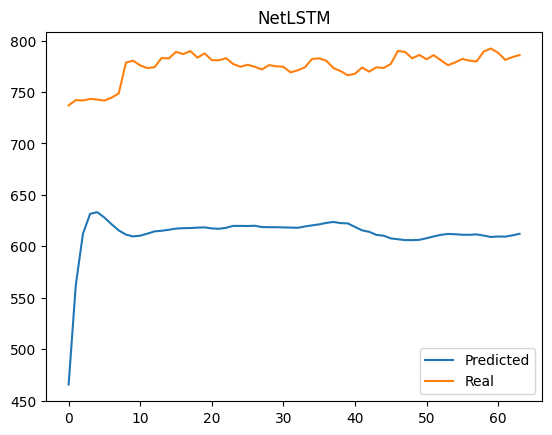

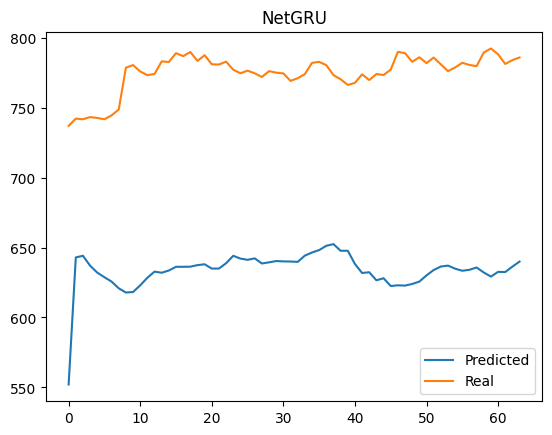

In [ ]:
models_values = []

for opt in optimizers:
    predictions, values = opt.evaluate(test_loader, batch_size)
    vals = np.array([])
    preds = np.array([])
    for pred, value in zip(predictions, values):
        vals = np.append(vals, value)
        preds = np.append(preds, pred)
        
    vals = scaler.inverse_transform(vals.reshape(-1, 1))
    preds = scaler.inverse_transform(preds.reshape(-1, 1))

    plt.plot(preds, label="Predicted")
    plt.plot(vals, label="Real")
    plt.legend()
    plt.title(f"{opt.model.__class__.__name__}")
    plt.show()
    plt.close()
    models_values.append([opt.model.__class__.__name__, preds, vals])